In [222]:
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
import datetime
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from copy import copy
import numpy as np
import joblib

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Using TensorFlow backend.


In [143]:
df = pd.read_csv('lol_data_pre_processed.csv')

def change_win_values(win):
    if win == 'team_RED':
        return 0
    if win == 'team_BLUE':
        return 1
    
df['win'] = df['win'].apply(change_win_values)

In [144]:
names = df.name.unique()

In [211]:
values = list()
targets = list()

for name in names:
    df_new = df[df.name==name]
    
    del df_new['name']
    del df_new['team_blue']
    del df_new['team_red']
    del df_new['Unnamed: 0']
    del df_new['week']
    del df_new['frame_number']
    del df_new['second']
    
    target = df_new.pop('win')
    scaler = preprocessing.StandardScaler()
    X = scaler.fit_transform(df_new.values)
    values.append(X)
    targets.append(target.values)

In [213]:
sequences = list()
zielvariablen = list()

for value, target in zip(values, targets):
    n = len(value)
    n = n % 60
    value = value[:-n]
    target = target[:-n]
    n = len(value) / 60
    chunks_value  = np.array_split(value, n)
    chunks_target = np.array_split(target, n)
    for a,b in zip(chunks_value, chunks_target):
        sequences.append(a)
        zielvariablen.append(b)

In [214]:
len(sequences)

2183

In [215]:
len(zielvariablen[4])

60

In [216]:
zielvariablen_new = list()
for var in zielvariablen:
    #print(type(var))
    zielvariablen_new.append(var[0])

In [217]:
len(zielvariablen_new)

2183

In [218]:
sequences[0]

array([[-0.69939567, -1.22352341, -1.48464687, ..., -1.89861258,
        -0.73926453, -0.74330461],
       [-0.69939567, -1.22352341, -1.48464687, ..., -1.89861258,
        -0.73926453, -0.74330461],
       [-0.69939567, -1.22352341, -1.48464687, ..., -1.89861258,
        -0.73926453, -0.74330461],
       ...,
       [-0.69939567, -1.22352341, -1.48464687, ..., -1.89861258,
        -0.73926453, -0.74330461],
       [-0.69939567, -1.22352341, -1.48464687, ..., -1.89861258,
        -0.73926453, -0.74330461],
       [-0.69939567, -1.22352341, -1.48464687, ..., -1.89861258,
        -0.73926453, -0.74330461]])

In [232]:
X_train, X_test, y_train, y_test = train_test_split(sequences, zielvariablen_new, test_size=0.3, random_state=42)

In [247]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [299]:
def get_compiled_model():
  model = tf.keras.Sequential([
        tf.keras.layers.LSTM(256, input_shape=(60, 45)),
        tf.keras.layers.Dense(1, activation = 'sigmoid')
  ])

  model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.001),
                loss='binary_crossentropy',
                metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
  return model



In [300]:
model = get_compiled_model()

In [301]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 256)               309248    
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 257       
Total params: 309,505
Trainable params: 309,505
Non-trainable params: 0
_________________________________________________________________


In [302]:
history = []

In [316]:
history = model.fit(X_train, y_train, 
      epochs=15,  
      verbose=1, 
      validation_data=(X_test, y_test),
      batch_size=32)

Train on 1528 samples, validate on 655 samples
Epoch 1/15
1528/1528 [==============================] - 6s 4ms/sample - loss: 0.1772 - accuracy: 0.9365 - precision_8: 0.9238 - recall_8: 0.9495 - val_loss: 0.2393 - val_accuracy: 0.9099 - val_precision_8: 0.9099 - val_recall_8: 0.9179
Epoch 2/15
1528/1528 [==============================] - 7s 4ms/sample - loss: 0.3289 - accuracy: 0.8626 - precision_8: 0.8512 - recall_8: 0.8738 - val_loss: 0.4227 - val_accuracy: 0.7924 - val_precision_8: 0.8339 - val_recall_8: 0.7507
Epoch 3/15
1528/1528 [==============================] - 6s 4ms/sample - loss: 0.2920 - accuracy: 0.8737 - precision_8: 0.8784 - recall_8: 0.8632 - val_loss: 0.3304 - val_accuracy: 0.8748 - val_precision_8: 0.8689 - val_recall_8: 0.8944
Epoch 4/15
1528/1528 [==============================] - 6s 4ms/sample - loss: 0.2721 - accuracy: 0.8874 - precision_8: 0.8701 - recall_8: 0.9070 - val_loss: 0.3338 - val_accuracy: 0.8641 - val_precision_8: 0.9038 - val_recall_8: 0.8270
Epoch 5/1

In [311]:
figures = []
columns=["loss", "accuracy", "precision", "recall", "val_loss", "val_accuracy", "val_precision", "val_recall", "seed", "epoch"]
history_data = pd.DataFrame(columns=columns)

In [312]:

print(history.history)
epoch = 1
loss = history.history['loss']
accuracy = history.history['accuracy']
precision = history.history['precision_8']
recall = history.history['recall_8']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']
val_precision = history.history['val_precision_8']
val_recall = history.history['val_recall_8']
seed = np.repeat('1', len(loss))

for x in range(len(loss)):
    sample = {}
    sample.update({'loss': loss[x]})
    sample.update({'accuracy': accuracy[x]})
    sample.update({'precision': precision[x]})
    sample.update({'recall': recall[x]})
    sample.update({'val_loss': val_loss[x]})
    sample.update({'val_accuracy': val_accuracy[x]})
    sample.update({'val_precision': val_precision[x]})
    sample.update({'val_recall': val_recall[x]})
    sample.update({'seed': seed[x]})
    sample.update({'epoch': epoch})

    history_data = history_data.append(sample, ignore_index=True)
    epoch+=1

{'loss': [0.15132532514514724, 0.10386733285575638, 0.10016135270682928, 0.117336467064488, 0.32839231684569914, 0.1369788684926108, 0.11793066596329524, 0.2675357150469775, 0.25512803677489, 0.2135280952325666, 0.47125257075769117, 0.39124470925768007, 0.2719134125097884, 0.19710412995977553, 0.2546186437001403], 'accuracy': [0.95418847, 0.9679319, 0.9659686, 0.9633508, 0.8638743, 0.95222515, 0.96007854, 0.8985602, 0.8992147, 0.91753924, 0.77159685, 0.822644, 0.88481677, 0.9286649, 0.9024869], 'precision_8': [0.94293123, 0.9668435, 0.95816994, 0.94394904, 0.86092716, 0.9485488, 0.9505208, 0.89973265, 0.90971273, 0.92422193, 0.75062037, 0.816273, 0.86939824, 0.9192708, 0.90591395], 'recall_8': [0.96547145, 0.9681275, 0.9734396, 0.98406374, 0.86321384, 0.9548473, 0.96945554, 0.8937583, 0.8831341, 0.9070385, 0.80345285, 0.82602924, 0.9017264, 0.937583, 0.89508635], 'val_loss': [0.2672848406752557, 0.26190715648859514, 0.25935118861553325, 0.8604282982704293, 0.3421282408005409, 0.2531072

In [313]:
for item in figures:
    fig = plt.figure(figsize=(10,2))
    ax1
    fig.add_subplot(item[0])
    fig.add_subplot(item[1])
    fig.add_subplot(item[2])
    fig.add_subplot(item[3])

In [314]:
grouped = history_data.groupby('seed')

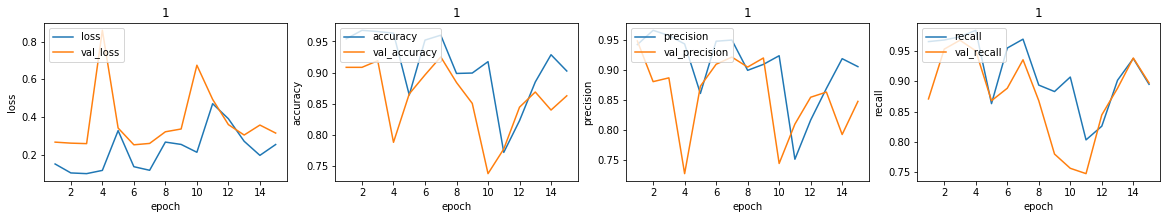

In [315]:
for name, group in grouped:
    fig = plt.figure(figsize=(20,2.9))
    
    ax1 = fig.add_subplot(1, 4, 1)
    ax2 = fig.add_subplot(1, 4, 2)
    ax3 = fig.add_subplot(1, 4, 3)
    ax4 = fig.add_subplot(1, 4, 4)
    
    ax1.plot(group['epoch'], group['loss'], label='loss')
    ax1.plot(group['epoch'], group['val_loss'], label='val_loss')
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('loss')
    ax1.set_title(name)
    ax1.legend()
    ax1.legend(loc="upper left")

    ax2.plot(group['epoch'], group['accuracy'], label='accuracy')
    ax2.plot(group['epoch'], group['val_accuracy'], label='val_accuracy')
    ax2.set_xlabel('epoch')
    ax2.set_ylabel('accuracy')
    ax2.set_title(name)
    ax2.legend()
    ax2.legend(loc="upper left")
    
    ax3.plot(group['epoch'], group['precision'], label='precision')
    ax3.plot(group['epoch'], group['val_precision'], label='val_precision')
    ax3.set_xlabel('epoch')
    ax3.set_ylabel('precision')
    ax3.set_title(name)
    ax3.legend()
    ax3.legend(loc="upper left")
    
    ax4.plot(group['epoch'], group['recall'], label='recall')
    ax4.plot(group['epoch'], group['val_recall'], label='val_recall')
    ax4.set_xlabel('epoch')
    ax4.set_ylabel('recall')
    ax4.set_title(name)
    ax4.legend()
    ax4.legend(loc="upper left")
    
    

In [317]:
model.save('model_weights/TEST-LSTM-v1.h5')